## Load Data

In [1]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    shuffle=True,
    image_size = (224,224),
    batch_size = 32
)

Mounted at /content/drive
Found 4500 files belonging to 3 classes.


In [3]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

## Data Visualization

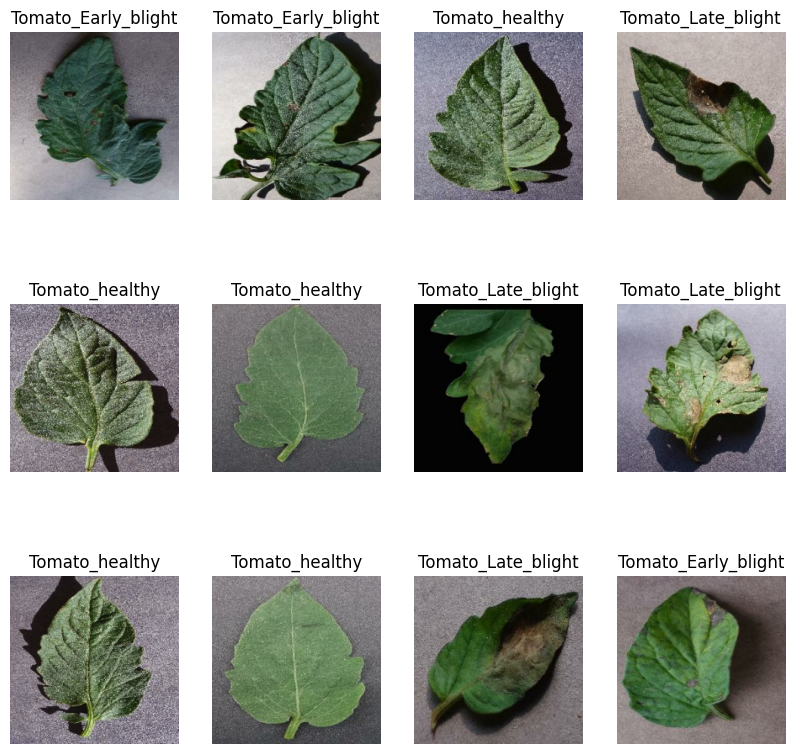

In [4]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

## Splitting Data

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


## Build and Train CNN Model

In [8]:
from tensorflow.keras.applications import VGG16

# Load the pre-trained model (before training section)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained model
base_model.trainable = False

# Add custom layers on top of the pre-trained model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Replace Flatten
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax'),  # Output layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model (training section)
history = model.fit(
    train_ds,
    epochs = 20,
    batch_size = 32,
    validation_data = val_ds
)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 612s 415ms/step - accuracy: 0.6712 - loss: 1.6768 - val_accuracy: 0.8906 - val_loss: 0.2820
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 32s 182ms/step - accuracy: 0.8855 - loss: 0.2851 - val_accuracy: 0.9196 - val_loss: 0.2129
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.9186 - loss: 0.2098 - val_accuracy: 0.9375 - val_loss: 0.1501
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.9312 - loss: 0.1725 - val_accuracy: 0.9598 - val_loss: 0.1097
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 0.9453 - loss: 0.1366 - val_accuracy: 0.9665 - val_loss: 0.0905
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 0.9612 - loss: 0.1134 - val_accuracy: 0.9844 - val_loss: 0.0694
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 0.9568 - loss: 0.1084 - val_accuracy: 0.9777 - val_loss: 0.0704
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.9605 - loss: 

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

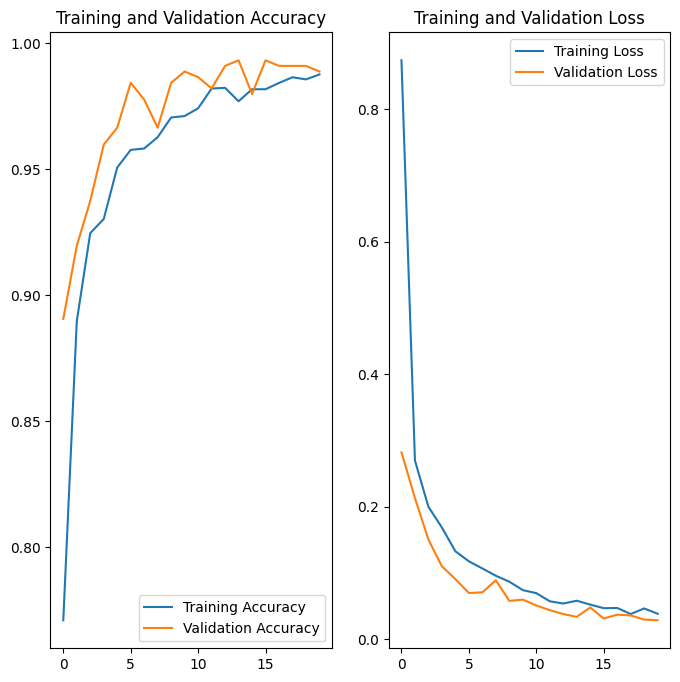

In [10]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label = 'Training Accuracy')
plt.plot(range(20), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label = 'Training Loss')
plt.plot(range(20), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluate Model

In [11]:
# Mendapatkan prediksi untuk data uji
# Assuming 'test_ds' is your TensorFlow Dataset for testing
images, labels = tuple(zip(*test_ds))  # Extract images and labels
images = np.concatenate(images, axis=0) # Combine into a single array
labels = np.concatenate(labels, axis=0) # Combine into a single array

predicted_probabilities = model.predict(images)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Mengonversi y_true menjadi array NumPy
y_true = labels

# Kode lainnya tetap sama
correct = np.nonzero(predicted_classes == y_true)[0]
incorrect = np.nonzero(predicted_classes != y_true)[0]

# Melakukan import classification_report dari sklearn.metrics
from sklearn.metrics import classification_report

# Assuming 'class_names' is defined earlier in your code
target_names = class_names

# Menampilkan laporan klasifikasi
print(classification_report(y_true, predicted_classes, target_names=target_names))

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step
                     precision    recall  f1-score   support

Tomato_Early_blight       1.00      0.96      0.98       103
 Tomato_Late_blight       0.98      1.00      0.99       183
     Tomato_healthy       0.99      1.00      1.00       194

           accuracy                           0.99       480
          macro avg       0.99      0.99      0.99       480
       weighted avg       0.99      0.99      0.99       480



## Prediction Result

In [12]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array (images [i]. numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


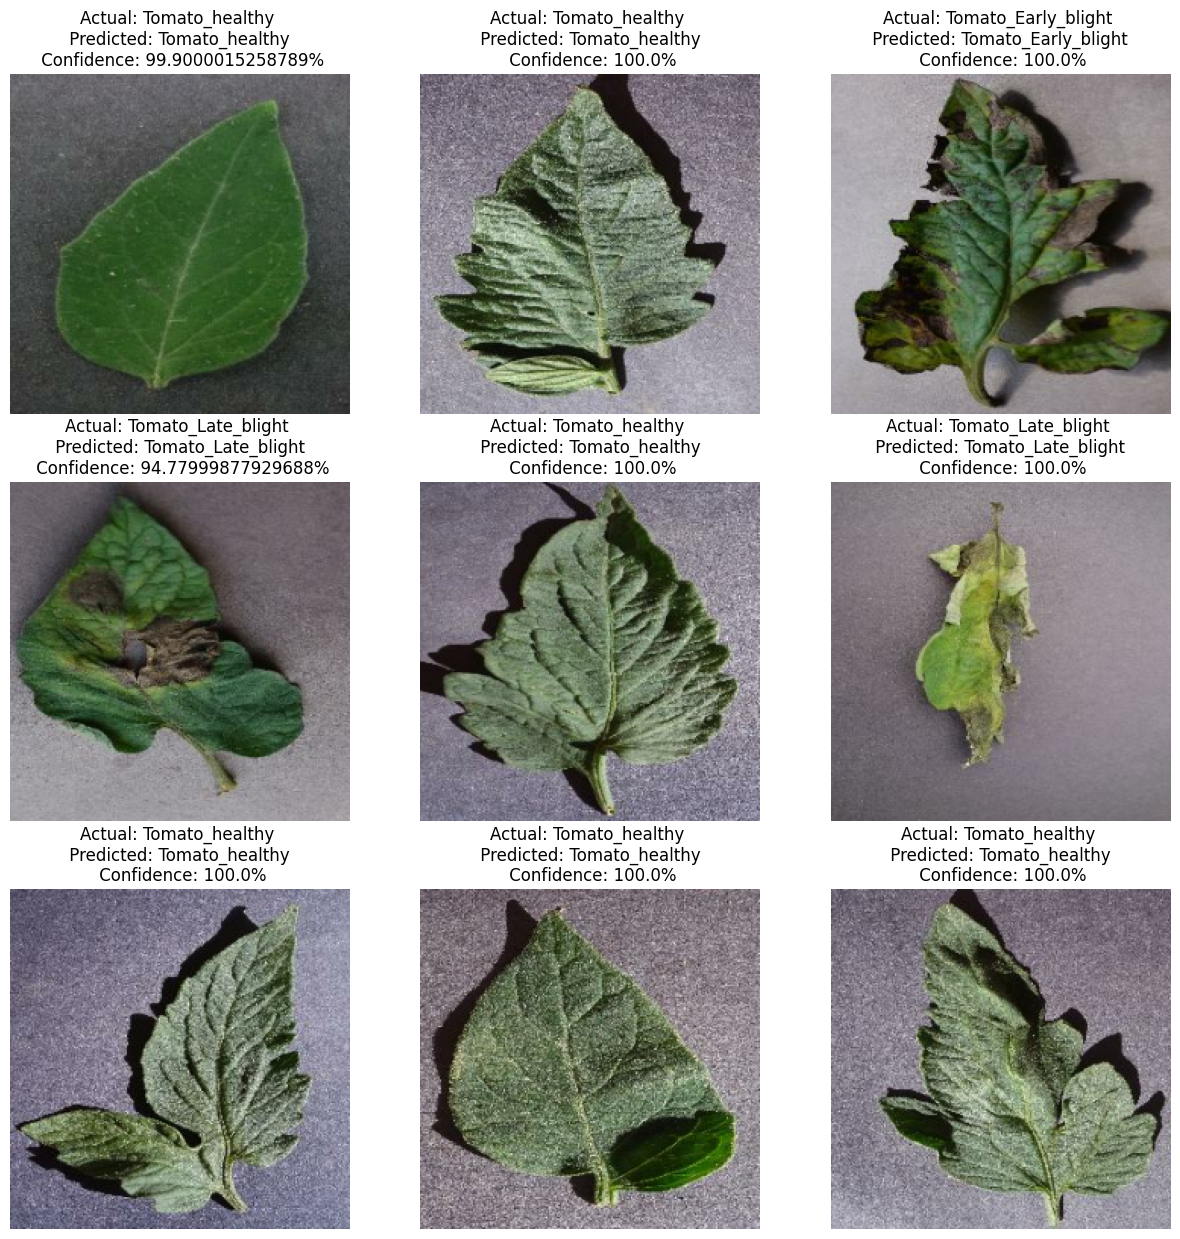

In [13]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1) :
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names [labels [i]]
    plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {confidence}%")

    plt.axis("off")